In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import TensorDataset, DataLoader
import random
from torch import nn
from torch._C._te import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from PIL import Image as im
from matplotlib import gridspec

In [2]:
TEMP_SUFFIX = "temp"
TEST_SUFFIX = "test"
IMAGE_EXTENSION = ".jpg"
DATASET_LOCATION = '/work/pcb-defect-detection-histogram-approach/binary_classification_dataset'
NOT_VALID_LOCATION = DATASET_LOCATION + "/not_valid"
VALID_LOCATION = DATASET_LOCATION + "/valid"
TOLERANCE = 5
HISTOGRAM_SIZE = 256
#TRAIN_VECTOR_SIZE = HISTOGRAM_SIZE * 2
TRAIN_VECTOR_SIZE = HISTOGRAM_SIZE
BATCH_SIZE = 16

In [3]:
def get_pcb_image_names(path):
    images = []
    for file in os.listdir(path):
        if file.endswith(IMAGE_EXTENSION):
            images.append(file)
    return images

In [4]:
def to_valid_image_name(name: str):
    return name.replace(TEST_SUFFIX, TEMP_SUFFIX)

In [5]:
def to_cumm_histo(diff_vector, s):
    # If empty -> return empty histogram (filled with zeros)
    n = len(diff_vector)
    if n == 0:
        return np.zeros(HISTOGRAM_SIZE)
    histo = np.bincount(diff_vector, minlength=HISTOGRAM_SIZE)
    cumm = np.cumsum(histo, axis=0)
    cumm = cumm / n
    return cumm

In [6]:
# def calculate_cumulative_histogram(image_diff_positive, image_diff_negative):
#     pos = image_diff_positive.flatten()
#     neg = image_diff_negative.flatten()
#     hist_pos, bins_pos = np.histogram(pos, 256, [0, 256])
#     hist_neg, bins_neg = np.histogram(neg, 256, [0, 256])

#     cumulative_hist_pos = np.cumsum(hist_pos)
#     cumulative_hist_neg = np.cumsum(hist_neg)

#     return (cumulative_hist_pos / len(pos)), (cumulative_hist_neg / len(neg))

# def find_difference_histograms(img1, img2):
#     a = np.int32(img1)
#     b = np.int32(img2)
#     diff = (a - b)
#     image_diff_positive = np.clip(diff, 0, 255)
#     image_diff_negative = np.clip(-diff, 0, 255)
#     return calculate_cumulative_histogram(image_diff_positive, image_diff_negative)

In [7]:
def cumulative_histo(diff_vector, size):
    n = len(diff_vector)
    if n == 0:
        return np.zeros(size)
    histo, _ = np.histogram(diff_vector, size, [0, size])
    cumm_histo = np.cumsum(histo)
    return cumm_histo / n

def calc_cumulative_histo(diff_vector):
    return cumulative_histo(diff_vector, HISTOGRAM_SIZE)

def find_difference_histograms(img1, img2):
    a = np.int32(img1)
    b = np.int32(img2)
    diff = np.abs(a - b).flatten()
 #   diff = diff[diff > 0]
    return calc_cumulative_histo(diff)

In [8]:
# def find_difference_histograms(img1, img2):
#     a = np.int32(img1)
#     b = np.int32(img2)
#     diff = (a - b)
#    # print(f"a = {a.shape} b = {b.shape} d = {diff.shape}")
#     # diff = (a - b).flatten()
#     # significantly_different = diff[np.abs(diff) > TOLERANCE]
#     # print(f"r = {significantly_different.shape}")
#     # positive = significantly_different[significantly_different > 0]
#     # negative = significantly_different[significantly_different < 0] * -1
#     positive = a[diff > TOLERANCE]
#     negative = a[diff < -TOLERANCE]
#     # print(f"({np.min(positive)}, {np.min(negative)}) {np.min(diff)} {np.min(a)} {np.min(b)}")
#     image_size = a.shape[0] * a.shape[1]
#     # print(f"image size = {image_size}")
#     # print(f"count positive differences = {len(positive)}")
#     # print(f"proportion of pos = {len(positive) / image_size}")
#     # print(f"proportion of neg = {len(negative) / image_size}")
#     pos_histo = to_cumm_histo(positive, image_size)
#     neg_histo = to_cumm_histo(negative, image_size)
#     return (pos_histo, neg_histo)

In [9]:
# def find_difference_histograms(img1, img2):
#     diff = (np.int32(img1) - np.int32(img2)).flatten()
#     significantly_different = diff[np.abs(diff) > TOLERANCE]
#     positive = significantly_different[significantly_different > 0]
#     negative = significantly_different[significantly_different < 0] * -1
#     pos_histo = to_cumm_histo(positive)
#     neg_histo = to_cumm_histo(negative)
#     return (pos_histo, neg_histo)

In [10]:
def get_compare_result_as_image(img1, img2, is_red):
	res_image = np.int32(img1)
	right_image = np.int32(img2)
	res = np.zeros((res_image.shape[0], res_image.shape[1], 3), dtype=int)
	res.fill(255)
	if is_red:
		res[(res_image - right_image) < -TOLERANCE] = [255, 0, 0]
	else:
		res[(res_image - right_image) > TOLERANCE] = [0, 0, 255]
	return res

In [11]:
def get_compare_result_as_image_both(img1, img2):
    res_image = np.int32(img1)
    right_image = np.int32(img2)
    res = np.zeros((res_image.shape[0], res_image.shape[1], 3), dtype=int)
    res.fill(255)
    res[(res_image - right_image) < -TOLERANCE] = [255, 0, 0]
    res[(res_image - right_image) > TOLERANCE] = [0, 0, 255]
    return res

In [30]:
def zero_matrix_same_size(img):
    v = np.zeros(img.shape)
    v.fill(255)
    return v

def calc_histo_with_max_intensity(img, max_intensity):
    a = np.int32(img)
    m = zero_matrix_same_size(a)
    mask = a < max_intensity
    m[mask] = img[mask]
    return cumulative_histo(a[mask].flatten(), max_intensity)

def calc_histo_defective_pixels(img_valid, img_defective):
    m = zero_matrix_same_size(img_valid)
    a = np.int32(img_valid)
    b = np.int32(img_defective)
    difference = np.abs(a - b)
    mask = difference > 0
    m[mask] = b[mask]
   # mask = np.logical_and(difference > 0, b < max_intensity)
    return cumulative_histo(m.flatten(), HISTOGRAM_SIZE)
    

In [41]:
# valid, invalid
def plot_compare_result(img1, img2, histo, c):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(img1)
    axarr[0,1].imshow(img2)
    
    # axarr[1,0].plot(histo)
    # axarr[1,0].set_xlabel('Intensity')
    # axarr[1,0].set_ylabel('Pixels')
    # axarr[1,1].imshow(get_compare_result_as_image_both(img1, img2))

    axarr[1, 0].plot(calc_histo_with_max_intensity(img2, HISTOGRAM_SIZE))
    axarr[1, 1].plot(calc_histo_defective_pixels(img1, img2))
    axarr[1, 0].set_xlim([0, HISTOGRAM_SIZE])
    axarr[1, 1].set_xlim([0, 200])
    axarr[1, 0].set_ylim([0, 1])
    axarr[1, 1].set_ylim([0, 0.3])
    # ax1.set_ylim([0, 5])

    axarr[1,0].set_xlabel('Intensity')
    axarr[1,0].set_ylabel('Pixels')
    axarr[1,1].set_xlabel('Intensity')
    axarr[1,1].set_ylabel('Pixels')

    # axarr[1,0].set_title('Positive')
    # axarr[1,1].set_title('Negative')

    # Setting the values for all axes.
 #   plt.setp(axarr, xlim=[0, 201])
    
   #  axarr[1,1].imshow(get_compare_result_as_image(img1, img2, True))
   #  axarr[1,1].imshow(get_compare_result_as_image(img1, img2, False))
   # plt.savefig(f"res{c}.jpg")
    f.tight_layout()
    plt.show()

In [42]:
plt.rcParams["figure.figsize"] = 8, 8

In [43]:
def plot_example(invalid_pcb_image_name, num_examples):
    print(f"Image {invalid_pcb_image_name}")
    invalid_pcb_image = cv2.imread(os.path.join(VALID_LOCATION, to_valid_image_name(invalid_pcb_image_name)), cv2.IMREAD_GRAYSCALE)
    valid_pcb_image = cv2.imread(os.path.join(NOT_VALID_LOCATION, invalid_pcb_image_name), cv2.IMREAD_GRAYSCALE)
    histos = find_difference_histograms(invalid_pcb_image, valid_pcb_image)
    plot_compare_result(valid_pcb_image, invalid_pcb_image, histos, num_examples)

In [44]:
def plot_several_examples(num_examples):
	copy_examples = invalid_pcb_images_names.copy()
	random.shuffle(copy_examples)
	for invalid_pcb_image_name in copy_examples:
		if num_examples == 0:
			break
		plot_example(invalid_pcb_image_name, num_examples)
		num_examples -= 1

Image 00041234_test.jpg


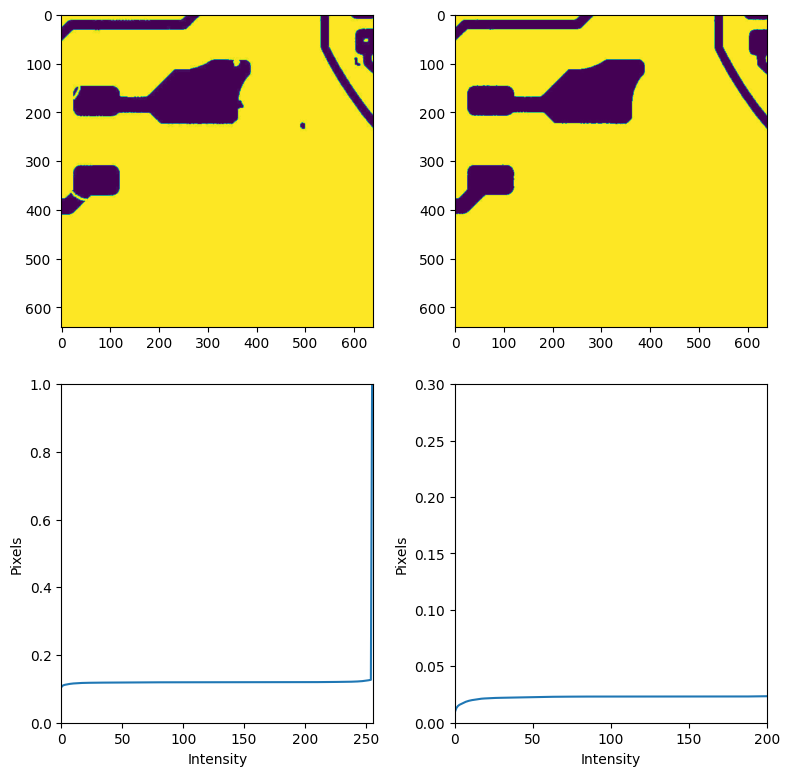

In [45]:
plot_example("00041234_test.jpg", 12)

In [18]:
invalid_pcb_images_names = get_pcb_image_names(Path(NOT_VALID_LOCATION))
print(f"Read PCB images = {invalid_pcb_images_names}")

Read PCB images = ['77000023_test.jpg', '20085014_test.jpg', '20085305_test.jpg', '20085142_test.jpg', '13000028_test.jpg', '13000113_test.jpg', '44000074_test.jpg', '12100047_test.jpg', '00041037_test.jpg', '90100083_test.jpg', '00041057_test.jpg', '12100063_test.jpg', '20085101_test.jpg', '13000204_test.jpg', '20085215_test.jpg', '12300148_test.jpg', '20085059_test.jpg', '20085098_test.jpg', '92000091_test.jpg', '12300244_test.jpg', '00041206_test.jpg', '12100002_test.jpg', '12100128_test.jpg', '00041220_test.jpg', '13000163_test.jpg', '13000142_test.jpg', '92000052_test.jpg', '20085015_test.jpg', '12100029_test.jpg', '20085306_test.jpg', '00041030_test.jpg', '13000067_test.jpg', '00041180_test.jpg', '92000107_test.jpg', '00041139_test.jpg', '12100001_test.jpg', '44000031_test.jpg', '12300218_test.jpg', '12100024_test.jpg', '50600059_test.jpg', '44000086_test.jpg', '13000179_test.jpg', '90100024_test.jpg', '12100054_test.jpg', '50600070_test.jpg', '20085012_test.jpg', '20085248_test.

Image 12100038_test.jpg


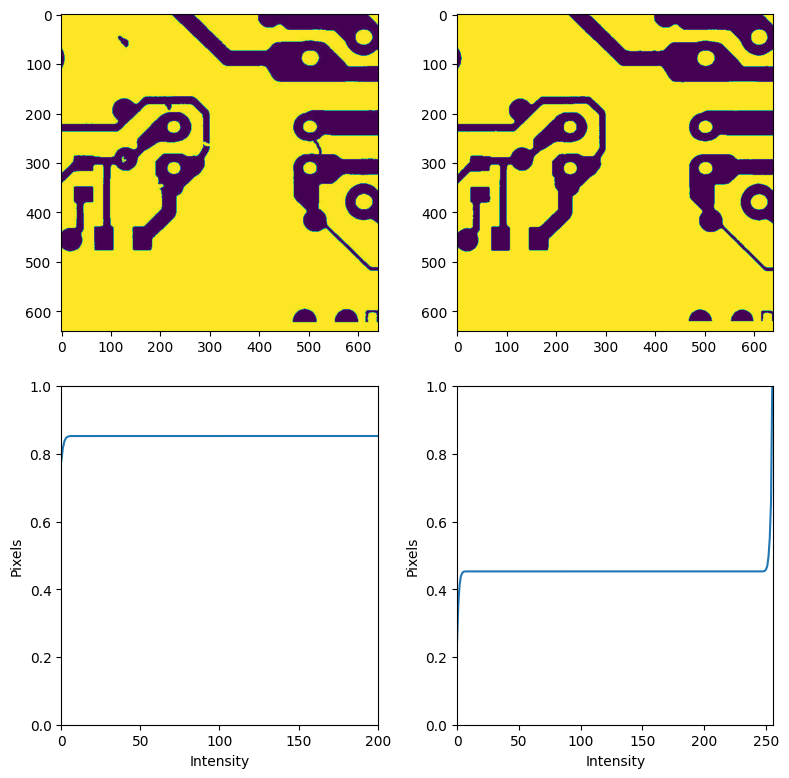

Image 90100070_test.jpg


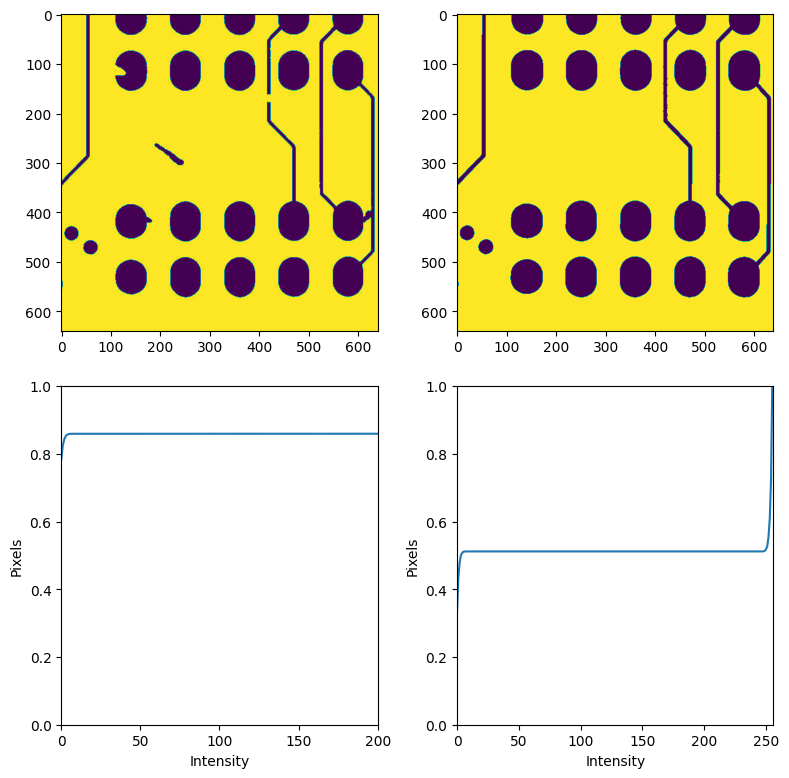

Image 12100013_test.jpg


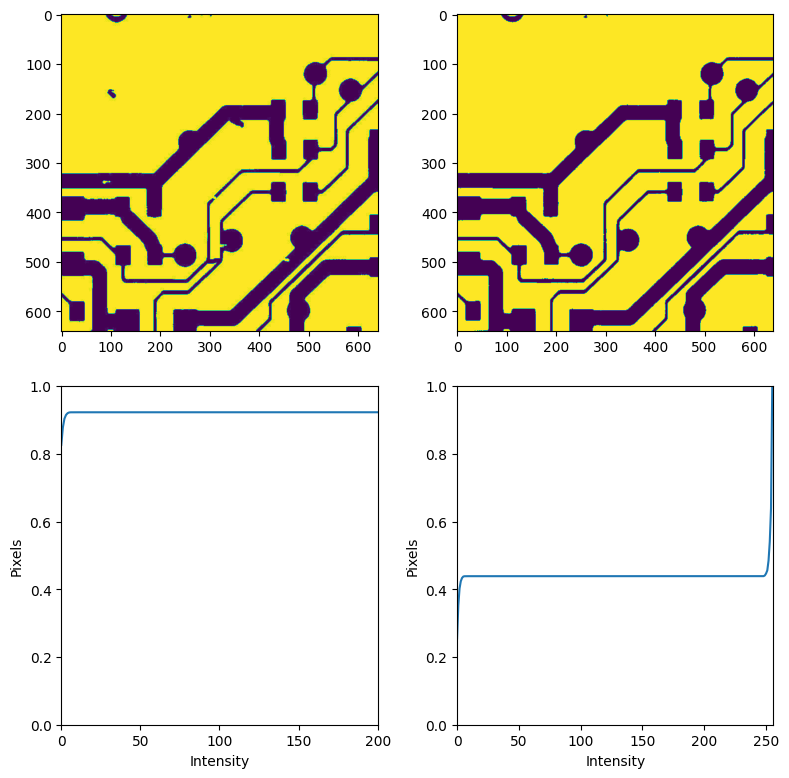

In [19]:
# Plot some examples!
plot_several_examples(3)
# plot_example('77000023_test.jpg')

In [37]:
# Prepare data
X = []
Y = []

N = len(invalid_pcb_images_names)

# Add invalid PCB histograms from images dataset
for invalid_pcb_image_name in invalid_pcb_images_names:
    invalid_pcb_image = cv2.imread(os.path.join(VALID_LOCATION, to_valid_image_name(invalid_pcb_image_name)), cv2.IMREAD_GRAYSCALE)
    valid_pcb_image = cv2.imread(os.path.join(NOT_VALID_LOCATION, invalid_pcb_image_name), cv2.IMREAD_GRAYSCALE)
    # (pos_histo, neg_histo) = find_difference_histograms(invalid_pcb_image, valid_pcb_image)
    # x = np.concatenate((pos_histo, neg_histo)).flatten()
    x = find_difference_histograms(invalid_pcb_image, valid_pcb_image)
    X.append(x)
    Y.append(0) # Its defect!

# Add valid PCB histograms
for i in range(N):
    
    #almost_horizontal = (np.random.rand(TRAIN_VECTOR_SIZE, 1) * 0.00001).flatten()
  #  almost_horizontal = (np.ones(TRAIN_VECTOR_SIZE, 1) + np.random.rand(TRAIN_VECTOR_SIZE, 1) * 0.00001).flatten()

    #almost_horizontal = np.zeros((TRAIN_VECTOR_SIZE, 1)).flatten()
    # almost_horizontal_cumm = np.cumsum(almost_horizontal, axis=0)
    almost_horizontal_cumm = np.ones(TRAIN_VECTOR_SIZE)
    X.append(almost_horizontal_cumm)
    Y.append(1)

tensor_X = torch.Tensor(X)
tensor_Y = torch.Tensor(Y)

dataset = TensorDataset(tensor_X, tensor_Y)
train_set, val_set = torch.utils.data.random_split(dataset, [0.90, 0.10])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
        	nn.Linear(in_features=TRAIN_VECTOR_SIZE, out_features=1),
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=128),
            # nn.ReLU(),
            # nn.Linear(in_features=128, out_features=64),
            # nn.ReLU(),
            # nn.Linear(in_features=64, out_features=1),
         #   nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


model = NeuralNetwork().to(device)
print(f"Model = {model}")

Model = NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [41]:
epochs = 50

In [42]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [43]:
def plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy):
    plt.figure(figsize=(10,5))
    plt.title("Training and Test Loss")
    plt.plot(list(map(lambda x : x.detach().numpy(), test_losses)), label="test")
    plt.plot(list(map(lambda x : x.detach().numpy(), train_losses)), label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title("Training and Test Accuracy")
    plt.plot(test_accuracy, label="test")
    plt.plot(train_accuracy, label="train")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [44]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

In [45]:
for epoch in range(epochs):
    train_accuracy_sum = 0
    count_batches = 0
    sum_loss_train = 0

    for _, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, labels = data

        y_logits = torch.sigmoid(model(image).squeeze(1))
        y_pred = torch.round(y_logits)

        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, labels.float())
        sum_loss_train += loss
        train_accuracy_sum += accuracy_fn(y_true=labels, y_pred=y_pred)
        count_batches += 1

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    acc = train_accuracy_sum / count_batches
    train_loss = sum_loss_train / count_batches

    test_accuracy_sum = 0
    test_count_batches = 0
    sum_loss_test = 0

    model.eval()
    m = 0
    with torch.inference_mode():
        for _, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            image, labels = data
            test_logits = model(image).squeeze(1)
            test_pred = torch.round(torch.sigmoid(test_logits))
            m = max(m, torch.max(torch.sigmoid(test_logits)))
            test_loss = loss_fn(test_logits, labels.float())
            sum_loss_test += test_loss
            test_count_batches += 1
            test_accuracy_sum += accuracy_fn(y_true=labels, y_pred=test_pred)
    print(f"Max acc = {m}")
    test_loss_avg = sum_loss_test / test_count_batches
    test_acc = test_accuracy_sum / test_count_batches

    train_losses.append(train_loss)
    train_accuracy.append(acc)
    test_losses.append(test_loss_avg)
    test_accuracy.append(test_acc)

    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss_avg:.5f}, Test acc: {test_acc:.2f}%")

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.07803233712911606
Epoch: 0 | Loss: 0.69791, Accuracy: 50.03% | Test loss: 1.40178, Test acc: 50.00%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.05128428339958191
Epoch: 1 | Loss: 0.69425, Accuracy: 50.03% | Test loss: 1.62990, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.041012171655893326
Epoch: 2 | Loss: 0.69391, Accuracy: 50.04% | Test loss: 1.74465, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.0331159271299839
Epoch: 3 | Loss: 0.69375, Accuracy: 50.04% | Test loss: 1.86266, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.02801201120018959
Epoch: 4 | Loss: 0.69366, Accuracy: 50.04% | Test loss: 1.94410, Test acc: 49.89%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.024156874045729637
Epoch: 5 | Loss: 0.69359, Accuracy: 50.04% | Test loss: 2.03226, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.021975504234433174
Epoch: 6 | Loss: 0.69354, Accuracy: 50.06% | Test loss: 2.07875, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.01911403052508831
Epoch: 7 | Loss: 0.69350, Accuracy: 50.05% | Test loss: 2.15405, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.017346980050206184
Epoch: 8 | Loss: 0.69346, Accuracy: 50.02% | Test loss: 2.20643, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.015802372246980667
Epoch: 9 | Loss: 0.69344, Accuracy: 50.02% | Test loss: 2.26175, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.014700256288051605
Epoch: 10 | Loss: 0.69342, Accuracy: 50.04% | Test loss: 2.30592, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.013445815071463585
Epoch: 11 | Loss: 0.69340, Accuracy: 50.04% | Test loss: 2.34427, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.012446998618543148
Epoch: 12 | Loss: 0.69338, Accuracy: 50.04% | Test loss: 2.40167, Test acc: 49.45%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.011715193279087543
Epoch: 13 | Loss: 0.69337, Accuracy: 50.04% | Test loss: 2.42946, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.010955954901874065
Epoch: 14 | Loss: 0.69335, Accuracy: 50.03% | Test loss: 2.46597, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.010331695899367332
Epoch: 15 | Loss: 0.69334, Accuracy: 50.05% | Test loss: 2.48711, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.009687191806733608
Epoch: 16 | Loss: 0.69333, Accuracy: 50.03% | Test loss: 2.51110, Test acc: 50.00%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.009224427863955498
Epoch: 17 | Loss: 0.69332, Accuracy: 50.05% | Test loss: 2.56530, Test acc: 49.45%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.008775964379310608
Epoch: 18 | Loss: 0.69331, Accuracy: 50.04% | Test loss: 2.60376, Test acc: 49.23%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.008280102163553238
Epoch: 19 | Loss: 0.69331, Accuracy: 50.03% | Test loss: 2.60165, Test acc: 49.89%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.007890046574175358
Epoch: 20 | Loss: 0.69330, Accuracy: 50.04% | Test loss: 2.62207, Test acc: 50.00%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.007574215531349182
Epoch: 21 | Loss: 0.69329, Accuracy: 50.05% | Test loss: 2.66732, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.007192504592239857
Epoch: 22 | Loss: 0.69329, Accuracy: 50.03% | Test loss: 2.68387, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.006898599676787853
Epoch: 23 | Loss: 0.69328, Accuracy: 50.04% | Test loss: 2.71245, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.006621233187615871
Epoch: 24 | Loss: 0.69328, Accuracy: 50.04% | Test loss: 2.72887, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.006364152766764164
Epoch: 25 | Loss: 0.69327, Accuracy: 50.04% | Test loss: 2.76840, Test acc: 49.45%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.006111220456659794
Epoch: 26 | Loss: 0.69327, Accuracy: 50.03% | Test loss: 2.78457, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.005898767150938511
Epoch: 27 | Loss: 0.69327, Accuracy: 50.05% | Test loss: 2.79173, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.005670954007655382
Epoch: 28 | Loss: 0.69326, Accuracy: 50.04% | Test loss: 2.82543, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.00549022201448679
Epoch: 29 | Loss: 0.69326, Accuracy: 50.06% | Test loss: 2.84313, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.005305995233356953
Epoch: 30 | Loss: 0.69325, Accuracy: 50.05% | Test loss: 2.85558, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.005129646044224501
Epoch: 31 | Loss: 0.69325, Accuracy: 50.04% | Test loss: 2.84275, Test acc: 50.22%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004966411739587784
Epoch: 32 | Loss: 0.69325, Accuracy: 50.04% | Test loss: 2.89166, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004802499897778034
Epoch: 33 | Loss: 0.69324, Accuracy: 50.02% | Test loss: 2.90364, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004660552833229303
Epoch: 34 | Loss: 0.69324, Accuracy: 50.04% | Test loss: 2.92635, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004519043955951929
Epoch: 35 | Loss: 0.69324, Accuracy: 50.03% | Test loss: 2.93037, Test acc: 49.89%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004399741068482399
Epoch: 36 | Loss: 0.69324, Accuracy: 50.04% | Test loss: 2.97065, Test acc: 49.45%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.0042687938548624516
Epoch: 37 | Loss: 0.69324, Accuracy: 50.03% | Test loss: 2.96132, Test acc: 49.89%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004161117598414421
Epoch: 38 | Loss: 0.69323, Accuracy: 50.04% | Test loss: 2.98171, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.004049788694828749
Epoch: 39 | Loss: 0.69323, Accuracy: 50.03% | Test loss: 3.00301, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.003936715889722109
Epoch: 40 | Loss: 0.69323, Accuracy: 50.04% | Test loss: 3.01848, Test acc: 49.67%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.003853241913020611
Epoch: 41 | Loss: 0.69323, Accuracy: 50.06% | Test loss: 3.03677, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.0037439120933413506
Epoch: 42 | Loss: 0.69323, Accuracy: 50.03% | Test loss: 3.05252, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.003658984089270234
Epoch: 43 | Loss: 0.69322, Accuracy: 50.06% | Test loss: 3.03179, Test acc: 50.11%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.00356713286601007
Epoch: 44 | Loss: 0.69322, Accuracy: 50.04% | Test loss: 3.05892, Test acc: 49.89%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.0034795745741575956
Epoch: 45 | Loss: 0.69322, Accuracy: 50.03% | Test loss: 3.10603, Test acc: 49.34%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.00339906825684011
Epoch: 46 | Loss: 0.69322, Accuracy: 50.04% | Test loss: 3.11215, Test acc: 49.45%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.003329237224534154
Epoch: 47 | Loss: 0.69322, Accuracy: 50.05% | Test loss: 3.11676, Test acc: 49.56%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.0032514266204088926
Epoch: 48 | Loss: 0.69322, Accuracy: 50.06% | Test loss: 3.11611, Test acc: 49.78%


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Max acc = 0.003179385559633374
Epoch: 49 | Loss: 0.69321, Accuracy: 50.03% | Test loss: 3.14197, Test acc: 49.56%


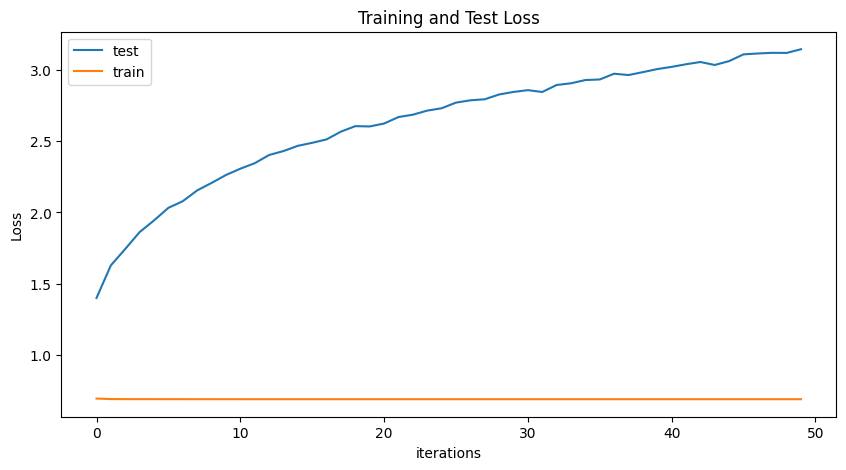

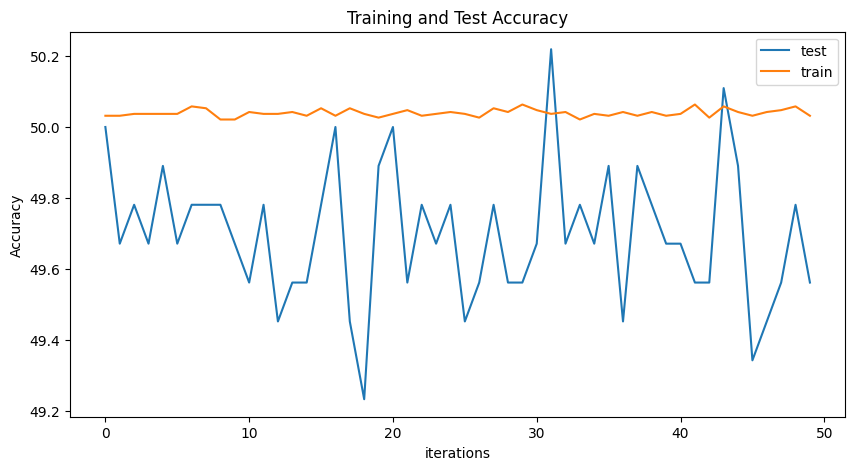

In [46]:
plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)

In [47]:
def plot_result(img1, img2, histos, prob, v):
	# (pos_histo, neg_histo) = histos
	f, axarr = plt.subplots(2,2)
	if prob == 0:
		axarr[0, 0].set_title(f"Defective (probability that PCB is valid = {v})")
	else:
		axarr[0, 0].set_title(f"Valid with probability = {v}")
	axarr[0,0].imshow(img1)
	axarr[0,1].imshow(img2)
	axarr[1,0].plot(histos)
	# axarr[1,1].plot(neg_histo)
	axarr[1,1].imshow(get_compare_result_as_image_both(img1, img2))
	axarr[1,0].set_xlabel('Intensity')
	axarr[1,0].set_ylabel('Pixels')
	f.tight_layout()
	
	# plt.legend()
	plt.show()

In [48]:
def plot_several_defective_results(num_examples):
	copy_examples = invalid_pcb_images_names.copy()
	random.shuffle(copy_examples)
	c = 0
	for invalid_pcb_image_name in copy_examples:
		if num_examples == 0:
			break
		invalid_pcb_image = cv2.imread(os.path.join(VALID_LOCATION, to_valid_image_name(invalid_pcb_image_name)), cv2.IMREAD_GRAYSCALE)
		valid_pcb_image = cv2.imread(os.path.join(NOT_VALID_LOCATION, invalid_pcb_image_name), cv2.IMREAD_GRAYSCALE)
		histos = find_difference_histograms(invalid_pcb_image, valid_pcb_image)
		x = histos.flatten()
		model.eval()
		with torch.inference_mode():
			v = torch.sigmoid(model(torch.Tensor([x])).squeeze(1))
			if (v == 0.5):
				c += 1
				# print("found")
			# if (v > 0.5):
			# 	continue
			probability = torch.round(v)
			plot_result(valid_pcb_image, invalid_pcb_image, histos, probability[0], v[0])
			num_examples -= 1
			print()
	print(f"found {c}")


In [49]:
def plot_several_not_defective_results(num_examples):
	copy_examples = invalid_pcb_images_names.copy()
	random.shuffle(copy_examples)
	for invalid_pcb_image_name in copy_examples:
		if num_examples == 0:
			break
		valid_pcb_image = cv2.imread(os.path.join(VALID_LOCATION, to_valid_image_name(invalid_pcb_image_name)), cv2.IMREAD_GRAYSCALE)
		# (pos_histo, neg_histo) = find_difference_histograms(valid_pcb_image, valid_pcb_image)
		histos = find_difference_histograms(valid_pcb_image, valid_pcb_image)
		model.eval()
		with torch.inference_mode():
			v = torch.sigmoid(model(torch.Tensor([histos.flatten()])).squeeze(1))
			probability = torch.round(v)
			plot_result(valid_pcb_image, valid_pcb_image, histos, probability[0], v[0])
			num_examples -= 1
			print()

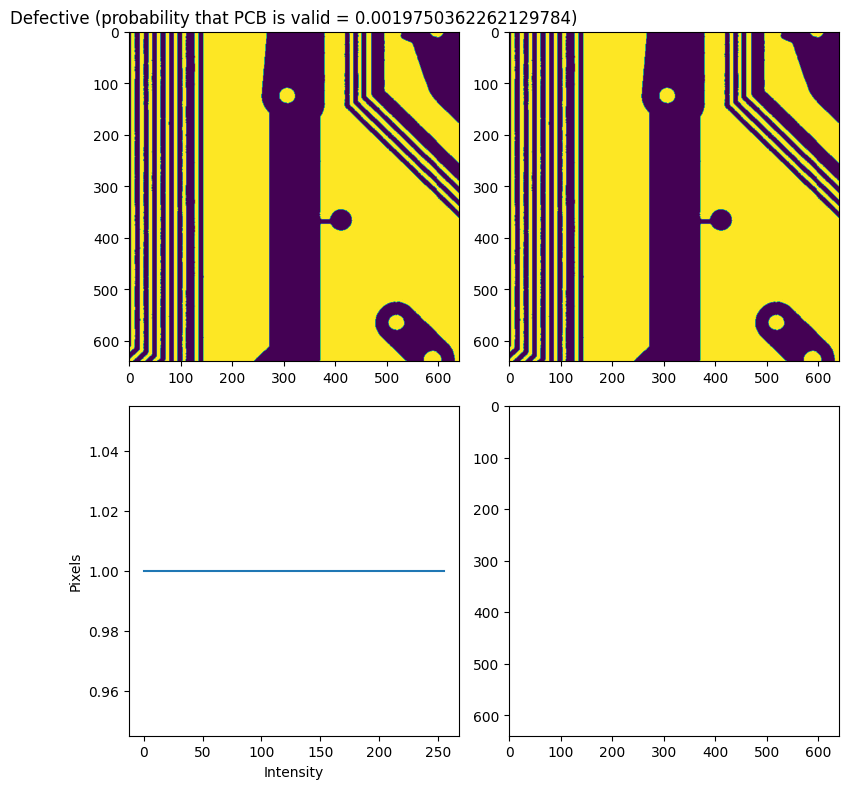

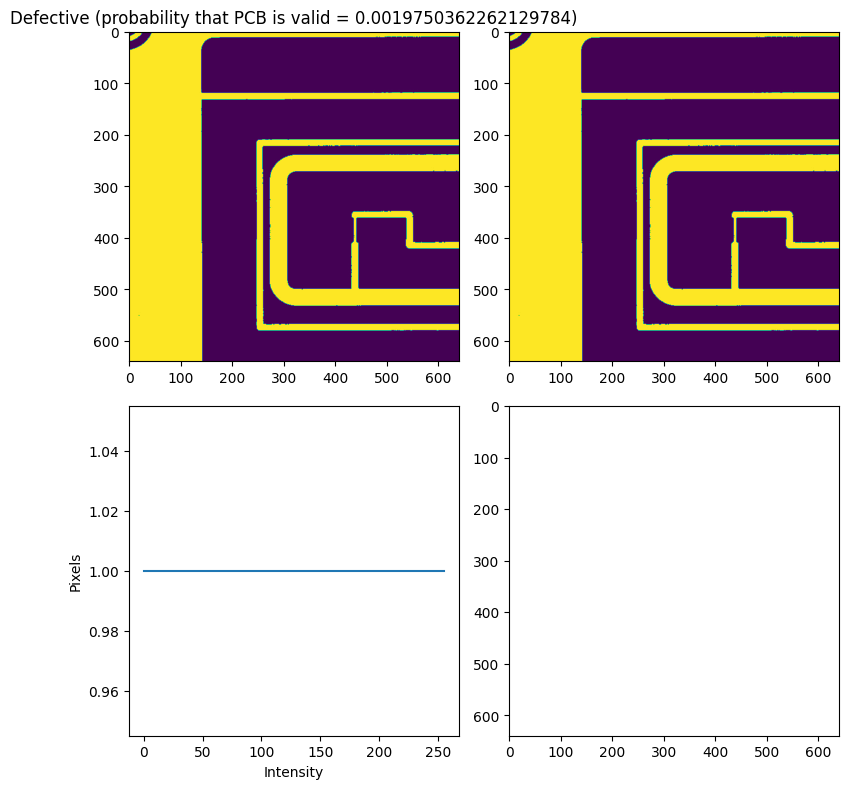

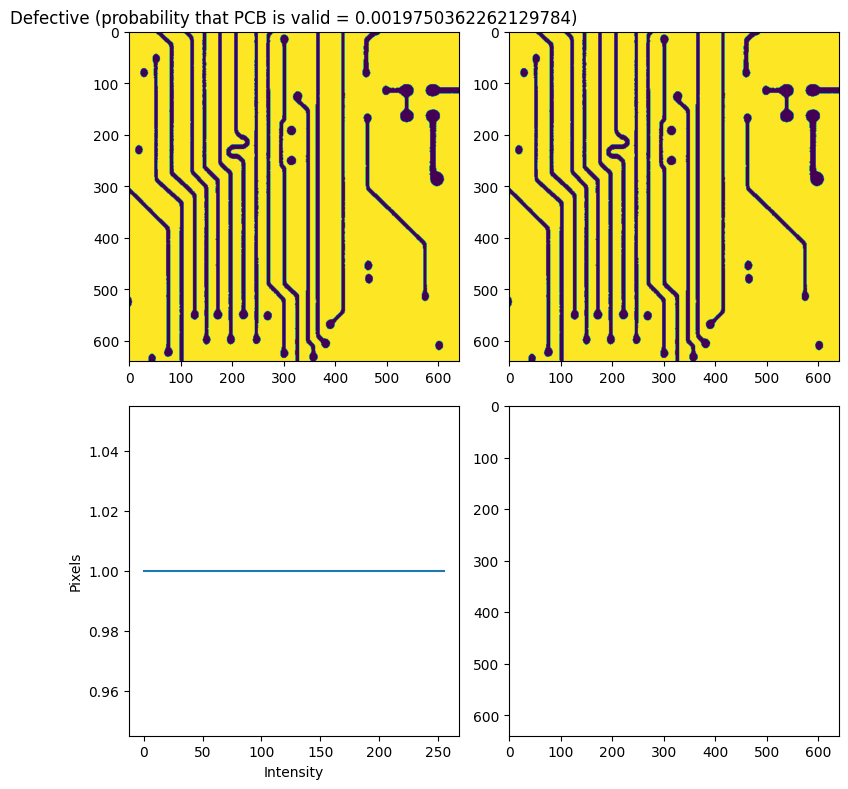

In [50]:
plot_several_not_defective_results(3)

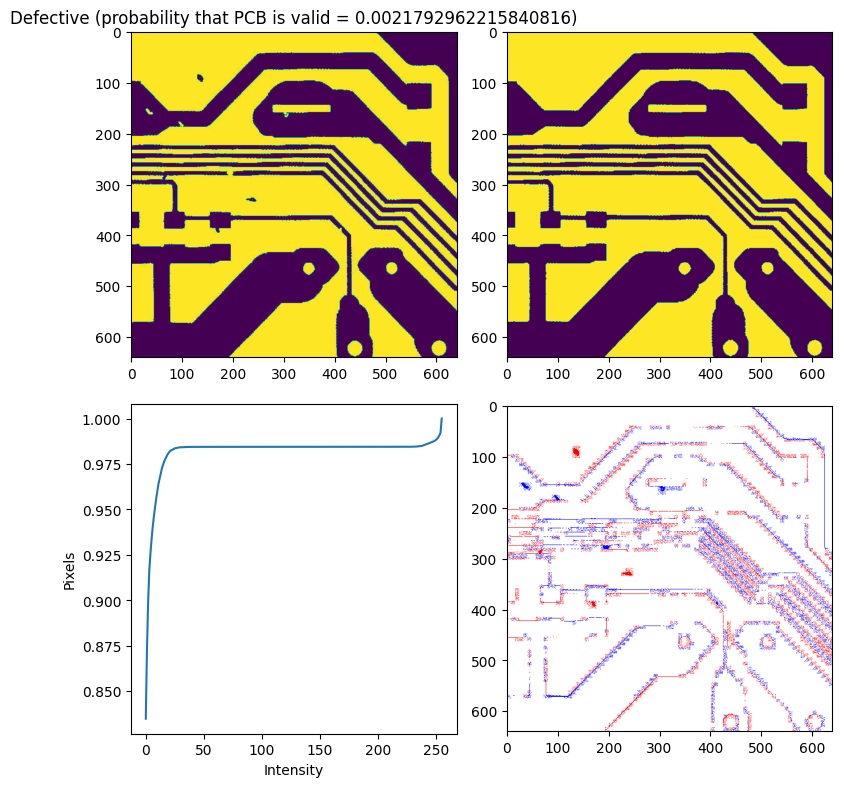

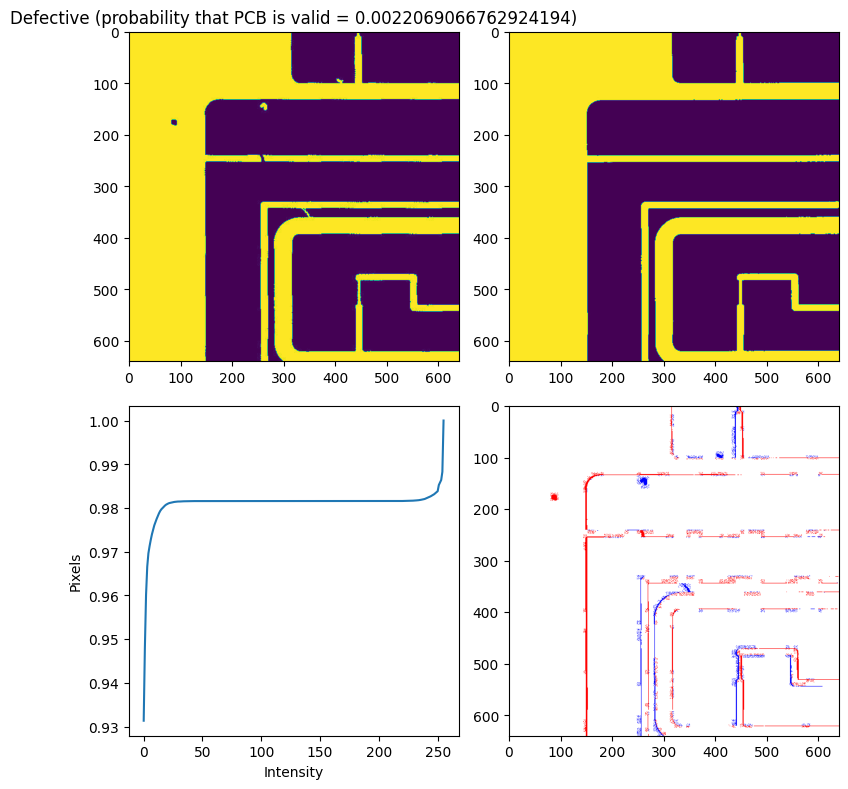

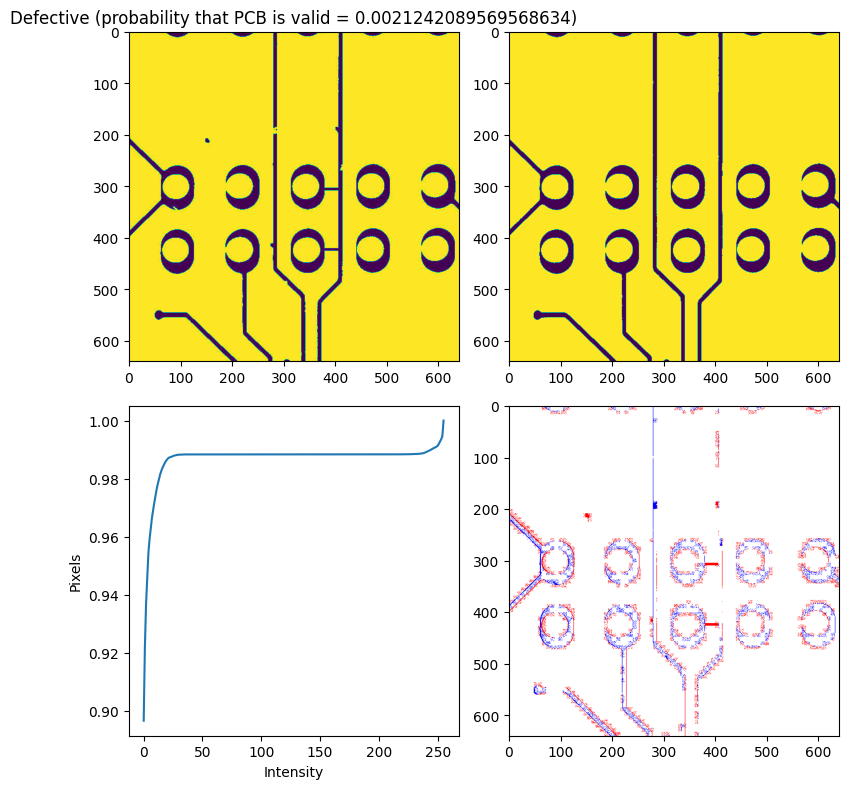


found 0


In [51]:
plot_several_defective_results(3)